In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [3]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface area of the glass wall
Sc = Si = 5 * Sg    # m² surface area of concrete & insulation of the 5 walls

In [4]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [5]:
concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': 5 * l**2}            # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': 5 * l**2}          # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': l**2}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,45
Layer_in,0.027,55.0,1210,0.08,45
Glass,1.400,2500.0,1210,0.04,9


In [6]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

In [7]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


In [9]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

,Conductance
Layer_out,315.0000
Layer_in,15.1875
Glass,315.0000


In [10]:
# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

In [11]:
# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']

In [12]:
T_int = 273.15 + np.array([0, 40])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + np.array([10, 30])
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ {coeff}')

T_int = 273.15 + 20
coeff = np.round((4 * σ * T_int**3), 1)
print(f'For (T/K - 273.15)°C = 20°C, 4σT³ = {4 * σ * T_int**3:.1f} W/(m²·K)')

For 0°C < (T/K - 273.15)°C < 40°C, 4σT³/[W/(m²·K)] ∈ [4.6 7. ]
For 10°C < (T/K - 273.15)°C < 30°C, 4σT³/[W/(m²·K)] ∈ [5.1 6.3]
For (T/K - 273.15)°C = 20°C, 4σT³ = 5.7 W/(m²·K)


In [13]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

In [14]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

In [15]:
# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

In [16]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

In [17]:
# P-controler gain
# Kp = 1e4            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
Kp = 0

In [18]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

In [19]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,18216000.0
Layer_in,239580.0
Glass,1089000.0


In [20]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,18216000.0
Layer_in,239580.0
Glass,1089000.0
Air,32400.0


In [39]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11']

In [40]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

pd.DataFrame(A, index=q, columns=θ)

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7
q0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
q2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
q3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
q4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
q5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
q6,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
q7,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
q9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0


In [41]:
G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

,0
q0,1125.000000
q1,630.000000
q2,630.000000
q3,30.375000
q4,30.375000
q5,44.786824
q6,360.000000
q7,72.000000
q8,165.789474
q9,630.000000


In [42]:
neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass']])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

,0
θ0,0.0
θ1,18216000.0
θ2,0.0
θ3,239580.0
θ4,0.0
θ5,0.0
θ6,32400.0
θ7,1089000.0


In [43]:
b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp'],
              index=q)

In [44]:
f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa'],
              index=θ)

In [45]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

,0
θ0,0.0
θ1,0.0
θ2,0.0
θ3,0.0
θ4,0.0
θ5,0.0
θ6,1.0
θ7,0.0


In [46]:
# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

In [47]:
# TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

In [48]:
# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

In [49]:
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

In [2]:
# variation 4 : No imposed time-step

controller = False
neglect_air_glass_capacity = False
imposed_time_step = False

# variation 5 : imposed time-step

# controller = False
# neglect_air_glass_capacity = False
# imposed_time_step = True
# Δt = 498    # s, imposed time step

# variation 6 : Neglecting air and glass capcities

# controller = False
# neglect_air_glass_capacity = True
# imposed_time_step = False



In [51]:
print('Matrices and vectors for thermal circuit from Figure 1') 
df = pd.read_csv('./toy_model/TC_0.csv')
df.style.apply(lambda x: ['background-color: yellow'
                          if x.name in df.index[-3:] or c in df.columns[-2:]
                          else '' for c in df.columns], axis=1)

Matrices and vectors for thermal circuit from Figure 1


,A,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,G,b
0,q0,1,0.000000,0,0,0,0,0,0,1125.000000,To
1,q1,-1,1.000000,0,0,0,0,0,0,630.000000,0
2,q2,0,-1.000000,1,0,0,0,0,0,630.000000,0
3,q3,0,0.000000,-1,1,0,0,0,0,30.375000,0
4,q4,0,0.000000,0,-1,1,0,0,0,30.375000,0
5,q5,0,0.000000,0,0,-1,1,0,0,44.786824,0
6,q6,0,0.000000,0,0,-1,0,1,0,360.000000,0
7,q7,0,0.000000,0,0,0,-1,1,0,72.000000,0
8,q8,0,0.000000,0,0,0,0,0,1,165.789474,To
9,q9,0,0.000000,0,0,0,1,0,-1,630.000000,0


In [52]:
# MODEL
# =====
# Thermal circuit
TC = dm4bem.file2TC('./toy_model/TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q11'] = 1e3        # Kp -> ∞, almost perfect controller

if neglect_air_glass_capacity:
    TC['C']['θ6'] = TC['C']['θ7'] = 0
    # or
    TC['C'].update({'θ6': 0, 'θ7': 0})

In [53]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

In [54]:
bss = np.zeros(12)        # temperature sources b for steady state
bss[[0, 8, 10]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(8)         # flow-rate sources f for steady state

In [55]:
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

θss = [10. 10. 10. 10. 10. 10. 10. 10.] °C


In [56]:
bss = np.zeros(12)        # temperature sources b for steady state

fss = np.zeros(8)         # flow-rate sources f for steady state
fss[[6]] = 1000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')

θssQ = [ 0.14  0.39  0.65  5.88 11.12  5.57 12.26  4.41] °C


In [57]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [10 10 10 20  0  0  0  0]


In [58]:
inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values)
print(f'yss = {yss:.2f} °C')

yss = 10.00 °C


In [59]:
print(f'Error between DAE and state-space: {abs(θss[6] - yss):.2e} °C')

Error between DAE and state-space: 7.11e-15 °C


In [60]:
bT = np.array([0, 0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 1000, 0])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values)
print(f'yssQ = {yssQ:.2f} °C')

yssQ = 12.26 °C


In [61]:
print(f'Error between DAE and state-space: {abs(θssQ[6] - yssQ):.2e} °C')

Error between DAE and state-space: 8.88e-15 °C


In [62]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

In [63]:
# time step
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dm4bem.print_rounded_time('dtmax', dtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

dtmax = 498 s = 8.3 min
dt = 300 s = 5.0 min


In [64]:
if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

In [65]:
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

t_settle = 176132 s = 48.9 h


In [66]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

duration = 176400 s = 49.0 h


In [67]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [68]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0                      # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [69]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

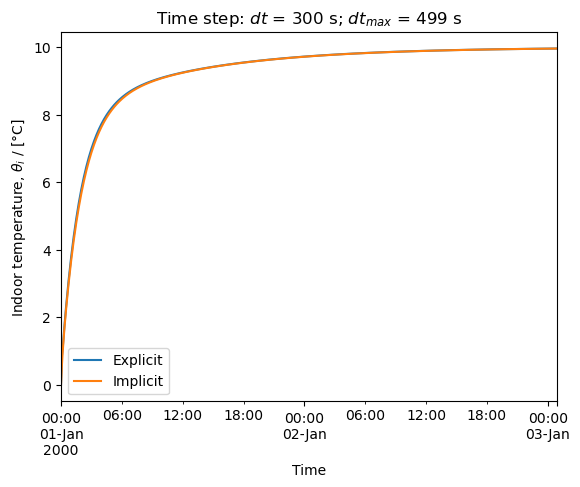

In [70]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()

In [71]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θss[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9645 °C


In [72]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}S")
# Create input_data_set
To = 0 * np.ones(n)         # outdoor temperature
Ti_sp =  20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo = Φi = Φa                # solar radiation
Qa = 1000 * np.ones(n)      # auxiliary heat sources
data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)

# Get inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [73]:
# Initial conditions
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [74]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

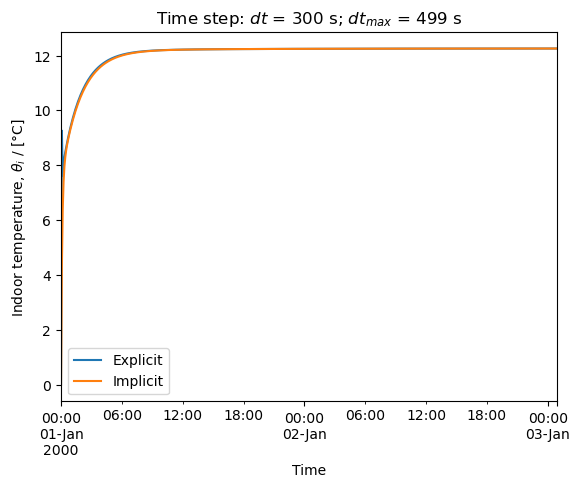

In [75]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / [°C]')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
plt.show()

In [76]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θssQ[6]):.4f} °C')
print(f'- state-space model: {float(yssQ):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ6"].tail(1).values[0]:.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 12.2566 °C
- state-space model: 12.2566 °C
- steady-state response to step input: 12.2549 °C
